In [1]:
import torch

from lafomo.datasets import P53Data
from lafomo.variational.models import SingleLinearLFM
from lafomo.variational.trainer import P53ConstrainedTrainer
from lafomo.options import VariationalOptions
from lafomo.utilities.torch import save, load
from lafomo.plot import Plotter

from matplotlib import pyplot as plt




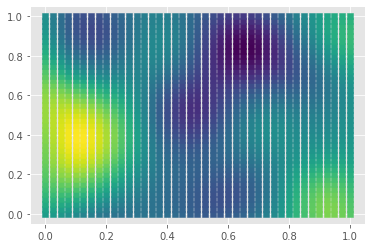

In [24]:
import numpy as np

import pandas as pd
gene = pd.read_csv('../lafomo/data/demToy1GPGene.csv')
tf = pd.read_csv('../lafomo/data/demToy1GPmRNA.csv')
gene = gene.values

plt.scatter(gene[:, 0], gene[:, 1], c=gene[:, 2], marker='s')

In [ ]:
from fenics import *
from fenics_adjoint import *

import torch_fenics

# Declare the FEniCS model corresponding to solving the Poisson equation
# with variable source term and boundary value
class Poisson(torch_fenics.FEniCSModule):
    # Construct variables which can be in the constructor
    def __init__(self):
        # Call super constructor
        super().__init__()

        # Create function space
        mesh = UnitIntervalMesh(20)
        self.V = FunctionSpace(mesh, 'P', 1)

        # Create trial and test functions
        u = TrialFunction(self.V)
        self.v = TestFunction(self.V)

        # Construct bilinear form
        self.a = inner(grad(u), grad(self.v)) * dx

    def solve(self, f, g):
        # Construct linear form
        L = f * self.v * dx

        # Construct boundary condition
        bc = DirichletBC(self.V, g, 'on_boundary')

        # Solve the Poisson equation
        u = Function(self.V)
        solve(self.a == L, u, bc)

        # Return the solution
        return u

    def input_templates(self):
        # Declare templates for the inputs to Poisson.solve
        return Constant(0), Constant(0)
